L'objectif de ce notebook est de réaliser une transformée de fourier glissante sur un audio pour en extraire la voix seulement en utilisant le gpu pour accelerer l'opération.
En premier lieu, le plus pertinent me paraitrait être d'en developper une version cpu récursive pour povoir la convertir inteligement ensuite pour le gpu.

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import istft

In [3]:
fs, data = wavfile.read("audiocut.wav")
if len(data.shape) > 1: #passer en mono 
    data = data[:, 0]

In [4]:
def fft_recursive(x):
    N = len(x)
    if N <= 1:
        return x

    even = fft_recursive(x[0::2])
    odd = fft_recursive(x[1::2])

    T = [np.exp(-2j * np.pi * k / N) * odd[k] for k in range(N // 2)]

    return [even[k] + T[k] for k in range(N // 2)] + [even[k] - T[k] for k in range(N // 2)]

In [11]:
def fft_glissante_perso(x, fs, nperseg=1024, noverlap=None):
    """
    Implémentation maison de la FFT glissante (STFT) pour l'extraction de voix.
    :param x: Signal d'entrée
    :param fs: Fréquence d'échantillonnage
    :param nperseg: Taille des fenêtres FFT
    :param noverlap: Recouvrement (par défaut moitié de la fenêtre)
    :return: (frequencies, times, spectrogram)
    """
    if noverlap is None:
        noverlap = nperseg // 2

    step = nperseg - noverlap
    windows = []
    times = []

    for start in range(0, len(x) - nperseg + 1, step):
        segment = x[start:start + nperseg]
        # Fenêtrage (Hanning par défaut)
        segment = segment * np.hanning(nperseg)
        result = fft_recursive(segment)
        windows.append(np.abs(result))
        times.append(start / fs)

    spectrogram = np.array(windows).T  # transposé pour avoir fréquences en lignes
    frequencies = np.fft.fftfreq(nperseg, d=1/fs)  
    frequencies = frequencies[frequencies >= 0]  # Suppression des fréquences négatives
    spectrogram = spectrogram[:len(frequencies), :]  # Ajustement de la taille du spectrogramme
    return frequencies, times, spectrogram

freqs size: 512, spec shape: (512, 1176)
Aperçu des fréquences calculées : [  0.     46.875  93.75  140.625 187.5   234.375 281.25  328.125 375.
 421.875]


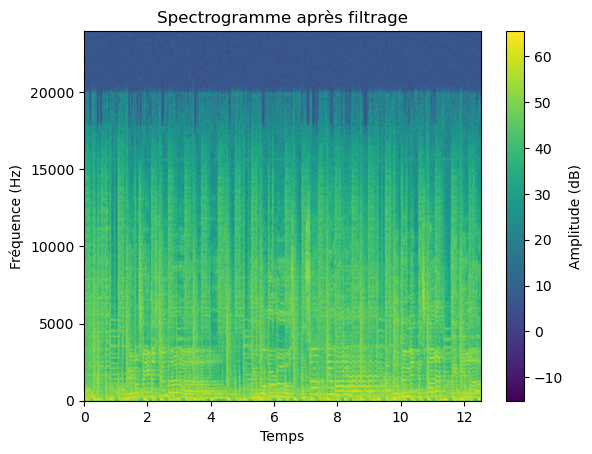

Valeurs min/max du spectrogramme après filtrage : 0.0307029819763886 3548781.095430389
Extraction de la voix terminée. Fichier sauvegardé sous 'voix_extraite.wav'


In [12]:
freqs, times, spec = fft_glissante_perso(data, fs, nperseg=1024)

# Vérification des dimensions et des fréquences
print(f"freqs size: {len(freqs)}, spec shape: {spec.shape}")
print("Aperçu des fréquences calculées :", freqs[:10])

# Filtrage des fréquences pour extraire la voix (300-4000 Hz)
spec_filtered = spec.copy()


# Vérification du spectrogramme après filtrage
plt.imshow(10 * np.log10(np.abs(spec_filtered) + 1e-10), aspect='auto', origin='lower',
           extent=[times[0], times[-1], freqs[0], freqs[-1]])  # Correction de l'échelle des fréquences
plt.xlabel("Temps")
plt.ylabel("Fréquence (Hz)")
plt.title("Spectrogramme après filtrage")
plt.colorbar(label="Amplitude (dB)")
plt.show()

# Vérifier les valeurs du spectrogramme avant reconstruction
print("Valeurs min/max du spectrogramme après filtrage :", np.min(spec_filtered), np.max(spec_filtered))

# Reconstruire le signal audio filtré
_, voice_only = istft(spec_filtered, fs)

# Normalisation du signal
voice_only = voice_only / np.max(np.abs(voice_only))  # Éviter le clipping

# Sauvegarde de l’audio extrait en int16
wavfile.write("voix_extraite.wav", fs, (voice_only * 32767).astype(np.int16))

print("Extraction de la voix terminée. Fichier sauvegardé sous 'voix_extraite.wav'")